In [9]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

In [66]:
import json

from langchain_openai import ChatOpenAI
from langchain_community.agent_toolkits import SQLDatabaseToolkit

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, MessageGraph
from langgraph.prebuilt.tool_node import ToolNode
from langchain_core.messages import AIMessage
from langchain_core.prompts import ChatPromptTemplate


# Define a new graph
workflow = MessageGraph()

toolkit = SQLDatabaseToolkit(db=db, llm=ChatOpenAI(model="gpt-4o"))
tools = toolkit.get_tools()

def first_tool_call(messages):
    human_input = messages[-1].content
    return [
        AIMessage(
            content="",
            tool_calls=[
                {
                    "name": "sql_db_list_tables",
                    "args": {
                    },
                    "id": "tool_abcd123",
                }
            ],
        )
    ]

workflow.add_node("first_tool_call", first_tool_call)
list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
workflow.add_node("list_tables_tool", ToolNode([list_tables_tool]))

get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
workflow.add_node("model_get_schema", ChatOpenAI(model="gpt-4o", temperature=0).bind_tools([get_schema_tool]))
workflow.add_node("get_schema_tool", ToolNode([get_schema_tool]))


from langchain.agents import tool

query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

Execute the correct query with the appropriate tool."""

query_check_prompt = ChatPromptTemplate.from_messages([("system", query_check_system),("user", "{query}")])
query_check = query_check_prompt | ChatOpenAI(model="gpt-4o", temperature=0)

@tool
def check_query_tool(query: str) -> str:
    """
    Use this tool to double check if your query is correct before executing it.
    """
    return query_check.invoke({"query": query}).content

@tool
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and get back the result..
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    return db.run_no_throw(query)

query_gen_system = """You are a SQL expert with a strong attention to detail.

Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

If you are unsure about your query, you should check it with the appropriate tool.

If you have enough information to answer the input question, simply reply with the final answer.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""
query_gen_prompt = ChatPromptTemplate.from_messages([("system", query_gen_system),("placeholder", "{messages}")])
query_gen = query_gen_prompt | ChatOpenAI(model="gpt-4o", temperature=0).bind_tools([db_query_tool, check_query_tool])
workflow.add_node("query_gen", lambda messages: query_gen.invoke({"messages": messages}))
workflow.add_node("sql_actions", ToolNode([check_query_tool, db_query_tool]))

def should_continue(messages):
    last_message = messages[-1]
    # If there is no tool call, then we finish
    if not last_message.tool_calls:
        return END
    else:
        return "sql_actions"

workflow.set_entry_point("first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges(
    "query_gen",
    should_continue,
)
workflow.add_edge("sql_actions", "query_gen")
app = workflow.compile()

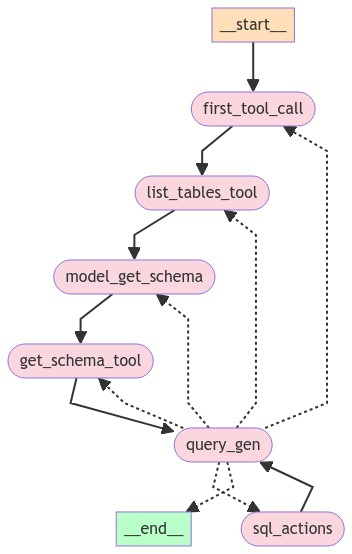

In [67]:
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [68]:
for event in app.stream("Which sales agent made the most in sales in 2009?"):
    print(event)
    print("----")

{'first_tool_call': [AIMessage(content='', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123'}])]}
----
{'list_tables_tool': [ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', tool_call_id='tool_abcd123')]}
----
{'model_get_schema': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_aUzZKSXs6q3ObT5zb6KNIwKE', 'function': {'arguments': '{"table_names":"Employee, Invoice"}', 'name': 'sql_db_schema'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 177, 'total_tokens': 195}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_319be4768e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a95cb99e-292a-40fc-9cc1-fb99904e5962-0', tool_calls=[{'name': 'sql_db_schema', 'args': {'table_names': 'Employee, Invoice'}, 'id': 'call_aUzZKSXs6q3ObT5zb6KNIwKE'}])}
----
{'get_schema_tool': [ToolMess

In [69]:
from langsmith import Client

client = Client()

# Create a dataset
examples = [
    ("Which country's customers spent the most? And how much did they spend?", "The country whose customers spent the most is the USA, with a total expenditure of $523.06"),
    ("What was the most purchased track of 2013?", "The most purchased track of 2013 was Hot Girl."),
    ("Which sales agent made the most in sales in 2009?", "Steve Johnson made the most sales in 2009"),
]

dataset_name = "SQL Database Agent"
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    inputs, outputs = zip(
        *[({"input": text}, {"expected": label}) for text, label in examples]
    )
    client.create_examples(inputs=inputs, outputs=outputs, dataset_id=dataset.id)

In [70]:
def agent_target(inputs):
    messages = app.invoke(inputs["input"])
    return messages[-1].content

In [71]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

cot_qa_evaluator = LangChainStringEvaluator("cot_qa")

In [72]:
from langsmith.evaluation import evaluate

results = evaluate(
    agent_target,
    data=dataset_name,
    evaluators=[cot_qa_evaluator],
    experiment_prefix=dataset_name,
)

View the evaluation results for experiment: 'SQL Database Agent-1fff0204' at:
https://smith.langchain.com/o/8867b20e-f7ba-4b0d-9138-3f15818f80bf/datasets/f7d59cbf-c388-4129-bbc8-3f48c8abec90/compare?selectedSessions=5682e7bc-e503-4ffe-8514-3f6a91fe5086




0it [00:00, ?it/s]

In [73]:
results = evaluate(
    agent_target,
    data=dataset_name,
    evaluators=[cot_qa_evaluator],
    experiment_prefix=dataset_name,
    num_repetitions=3
)

View the evaluation results for experiment: 'SQL Database Agent-fa38bec8' at:
https://smith.langchain.com/o/8867b20e-f7ba-4b0d-9138-3f15818f80bf/datasets/f7d59cbf-c388-4129-bbc8-3f48c8abec90/compare?selectedSessions=6c966064-16df-4fc0-a93c-a95b037c652c




0it [00:00, ?it/s]

Error running target function: 'sql_db_schema'
